In [1]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

sidr_data = genfromtxt('svidr_sim.csv', delimiter=',') #in the form of [t,S,V,I,D,R]

torch.manual_seed(1234)

In [2]:
sidr_data.shape

(6, 100)

In [3]:
%%time

PATH = 'svidr_norm_simple' 

class DINN(nn.Module):
    def __init__(self, t, S_data, V_data, I_data, D_data, R_data): #[t,S,V,I,D,R]
        super(DINN, self).__init__()
        self.N = 3e8 #population size
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S = torch.tensor(S_data)
        self.V = torch.tensor(V_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = []
        self.save = 2 #which file to save to

        self.alpha_tilda = torch.nn.Parameter(torch.rand(1,requires_grad=True))
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.sigma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.lbda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.rho_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        
        #find values for normalization
        self.S_max = max(self.S)
        self.V_max = max(self.V)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.V_min = min(self.V)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.V_hat = (self.V - self.V_min) / (self.V_max - self.V_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)

        #matrices (x5 for S,V,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 5)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 5)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 5)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 5)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 5)); self.m5[:, 4] = 1

        #NN
        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend(list([self.alpha_tilda, self.beta_tilda, self.sigma_tilda, self.lbda_tilda, self.rho_tilda]))


    @property
    def alpha(self):
        return torch.tanh(self.alpha_tilda) * 3.5e-2

    @property
    def beta(self):
        return torch.tanh(self.beta_tilda) *0.5
    
    @property
    def sigma(self):
        return torch.tanh(self.sigma_tilda) *0.1

    @property
    def lbda(self):
        return torch.tanh(self.lbda_tilda) *0.002
    
    @property
    def rho(self):
        return torch.tanh(self.rho_tilda)*0.5

    #nets
    class Net_sidr(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 5) #outputs S, V, I, D, R

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr
            
    def net_f(self, t_batch):
        sidr_hat = self.net_sidr(t_batch)

        S_hat, V_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3], sidr_hat[:,4]

        #S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #V_t
        sidr_hat.backward(self.m2, retain_graph=True)
        V_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        sidr_hat.backward(self.m3, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #D_t
        sidr_hat.backward(self.m4, retain_graph=True)
        D_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_t
        sidr_hat.backward(self.m5, retain_graph=True)
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        V = self.V_min + (self.V_max - self.V_min) * V_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        D = self.D_min + (self.D_max - self.D_min) * D_hat      
        R = self.R_min + (self.R_max - self.R_min) * R_hat

        f1_hat = S_hat_t - (-self.beta/self.N * S * I - self.alpha * S)  / (self.S_max - self.S_min)
        f2_hat = V_hat_t - (self.alpha * S - self.sigma * self.beta/self.N * V * I)  / (self.V_max - self.V_min)
        f3_hat = I_hat_t - (self.beta/self.N * S * I + self.sigma * self.beta/self.N * V * I - self.lbda * I - self.rho * I ) / (self.I_max - self.I_min)
        f4_hat = D_hat_t - (self.lbda * I) / (self.D_max - self.D_min)
        f5_hat = R_hat_t - (self.rho * I ) / (self.R_max - self.R_min)

        return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, S_hat, V_hat, I_hat, D_hat, R_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        self.losses = checkpoint['losses']

      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S_pred_list = []
        V_pred_list = []
        I_pred_list = []
        D_pred_list = []
        R_pred_list = []

        f1, f2, f3, f4, f5, S_pred, V_pred, I_pred, D_pred, R_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred)
        V_pred_list.append(self.V_min + (self.V_max - self.V_min) * V_pred) 
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
        D_pred_list.append(self.D_min + (self.D_max - self.D_min) * D_pred)
        R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)

        train_day = 90

        loss = (torch.mean(torch.square(self.S_hat[:train_day] - S_pred[:train_day]))+ 
                torch.mean(torch.square(self.V_hat[:train_day] - V_pred[:train_day]))+
                torch.mean(torch.square(self.I_hat[:train_day] - I_pred[:train_day]))+
                torch.mean(torch.square(self.D_hat[:train_day] - D_pred[:train_day]))+
                torch.mean(torch.square(self.R_hat[:train_day] - R_pred[:train_day]))+
                torch.mean(torch.square(f1[:train_day]))+
                torch.mean(torch.square(f2[:train_day]))+
                torch.mean(torch.square(f3[:train_day]))+
                torch.mean(torch.square(f4[:train_day]))+
                torch.mean(torch.square(f5[:train_day]))
                ) 

        #loss.backward(retain_graph=True)
        loss.backward()
        self.optimizer.step()
        self.scheduler.step(loss) 
        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)
          print('alpha: (goal 3.5e-3 ', self.alpha)
          print('beta: (goal 0.3 ', self.beta)
          print('sigma: (goal 0.05 ', self.sigma)
          print('lbda: (goal 1e-3 ', self.lbda)
          print('rho: (goal 0.1 ', self.rho)
          print('#################################') 

        #loss + model parameters update
        if epoch % 4000 == 9999:
          #checkpoint save
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              #'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

      return S_pred_list, V_pred_list, I_pred_list, D_pred_list, R_pred_list

Wall time: 0 ns


In [4]:
%%time

dinn = DINN(sidr_data[0], sidr_data[1], sidr_data[2], sidr_data[3], 
            sidr_data[4], sidr_data[5]) #in the form of [t,S,V,I,D,R]

learning_rate = 1e-5
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

# scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, mode='min', factor=0.1, patience=1000, min_lr=1e-6, eps=1e-8)

dinn.scheduler = scheduler

nepochs = int(4e5)

# S_pred_list, V_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(nepochs) #train

try: 
  S_pred_list, V_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(nepochs) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    S_pred_list, V_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(nepochs) #train
  elif dinn.save == 3:
    dinn.save = 2
    S_pred_list, V_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(nepochs) #train


starting training...


Epoch  0
alpha: (goal 3.5e-3  tensor([0.0010], grad_fn=<MulBackward0>)
beta: (goal 0.3  tensor([0.1908], grad_fn=<MulBackward0>)
sigma: (goal 0.05  tensor([0.0254], grad_fn=<MulBackward0>)
lbda: (goal 1e-3  tensor([0.0007], grad_fn=<MulBackward0>)
rho: (goal 0.1  tensor([0.0291], grad_fn=<MulBackward0>)
#################################

Epoch  1000
alpha: (goal 3.5e-3  tensor([0.0006], grad_fn=<MulBackward0>)
beta: (goal 0.3  tensor([0.1885], grad_fn=<MulBackward0>)
sigma: (goal 0.05  tensor([0.0254], grad_fn=<MulBackward0>)
lbda: (goal 1e-3  tensor([0.0007], grad_fn=<MulBackward0>)
rho: (goal 0.1  tensor([0.0285], grad_fn=<MulBackward0>)
#################################

Epoch  2000
alpha: (goal 3.5e-3  tensor([0.0011], grad_fn=<MulBackward0>)
beta: (goal 0.3  tensor([0.1839], grad_fn=<MulBackward0>)
sigma: (goal 0.05  tensor([0.0242], grad_fn=<MulBackward0>)
lbda: (goal 1e-3  tensor([0.0007], grad_fn=<MulBackward0>)
rho: (goal 0.1  tensor([0.0330], grad_fn=<

total loss:  1.580857132479293e-05


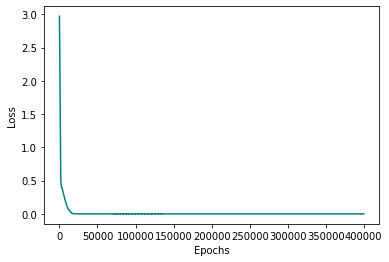

In [5]:
plt.plot(dinn.losses, color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')
print('total loss: ', dinn.losses[-1])

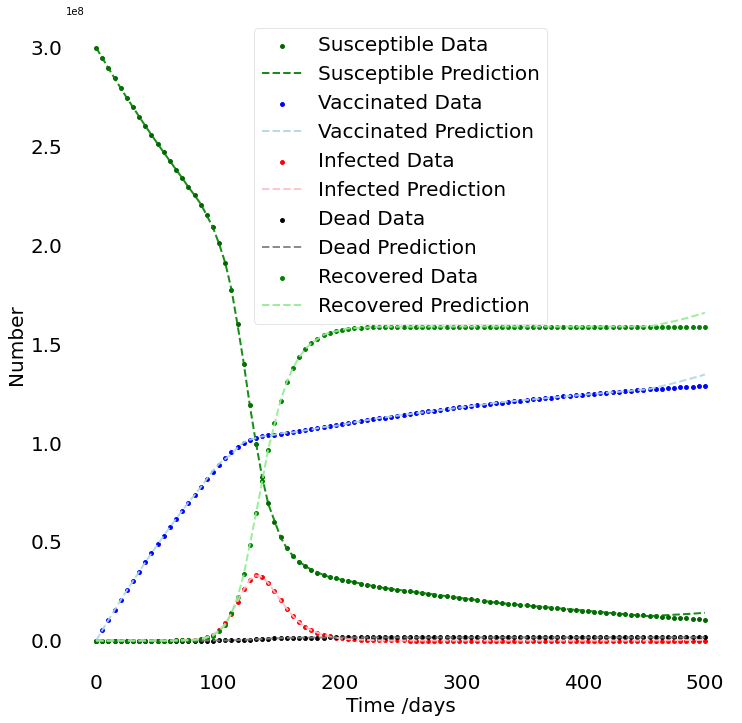

In [6]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')



ax.scatter(sidr_data[0], sidr_data[1], color = 'darkgreen', label='Susceptible Data', s=15)
ax.plot(sidr_data[0], S_pred_list[0].detach().numpy(), 'green', alpha=0.9, lw=2, label='Susceptible Prediction', linestyle='dashed')


ax.scatter(sidr_data[0], sidr_data[2], color = 'blue', label='Vaccinated Data', s=15)
ax.plot(sidr_data[0], V_pred_list[0].detach().numpy(), 'lightblue', alpha=0.9, lw=2, label='Vaccinated Prediction', linestyle='dashed')


ax.scatter(sidr_data[0], sidr_data[3], color = 'red', label='Infected Data', s=15)
ax.plot(sidr_data[0], I_pred_list[0].detach().numpy(), 'pink', alpha=0.9, lw=2, label='Infected Prediction', linestyle='dashed')


ax.scatter(sidr_data[0], sidr_data[4], color = 'black', label='Dead Data', s=15)
ax.plot(sidr_data[0], D_pred_list[0].detach().numpy(), 'grey', alpha=0.9, lw=2, label='Dead Prediction', linestyle='dashed')


ax.scatter(sidr_data[0], sidr_data[5], color = 'green', label='Recovered Data', s=15)
ax.plot(sidr_data[0], R_pred_list[0].detach().numpy(), 'lightgreen', alpha=0.9, lw=2, label='Recovered Prediction', linestyle='dashed')


ax.set_xlabel('Time /days',size = 20)
ax.set_ylabel('Number',size = 20)

ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
plt.xticks(size = 20)
plt.yticks(size = 20)
ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(prop={'size':20})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.savefig('covid_missing_I.pdf')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


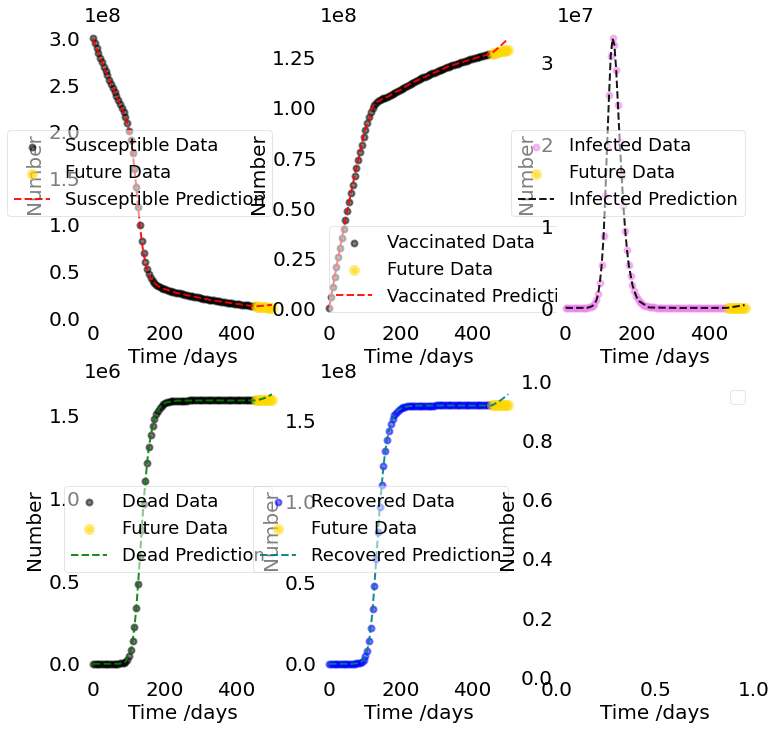

In [7]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

fig, ax = plt.subplots(2, 3, figsize = (12,12))

for i in range(2):
    for j in range(3):
        ax[i, j].set_facecolor('xkcd:white')


train_day = 90

ax[0, 0].scatter(sidr_data[0][:train_day], sidr_data[1][:train_day], c = 'black', alpha=0.5, lw=2, label='Susceptible Data')
ax[0, 0].scatter(sidr_data[0][train_day:], sidr_data[1][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 0].plot(sidr_data[0], S_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Susceptible Prediction', linestyle='dashed')

ax[0, 1].scatter(sidr_data[0][:train_day], sidr_data[2][:train_day], c = 'black', alpha=0.5, lw=2, label='Vaccinated Data')
ax[0, 1].scatter(sidr_data[0][train_day:], sidr_data[2][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 1].plot(sidr_data[0], V_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Vaccinated Prediction', linestyle='dashed')

ax[0, 2].scatter(sidr_data[0][:train_day], sidr_data[3][:train_day], c = 'violet', alpha=0.5, lw=2, label='Infected Data')
ax[0, 2].scatter(sidr_data[0][train_day:], sidr_data[3][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 2].plot(sidr_data[0], I_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='Infected Prediction', linestyle='dashed')

ax[1, 0].scatter(sidr_data[0][:train_day], sidr_data[4][:train_day], c = 'black', alpha=0.5, lw=2, label='Dead Data')
ax[1, 0].scatter(sidr_data[0][train_day:], sidr_data[4][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 0].plot(sidr_data[0], D_pred_list[0].detach().numpy(), 'green', alpha=0.9, lw=2, label='Dead Prediction', linestyle='dashed')

ax[1, 1].scatter(sidr_data[0][:train_day], sidr_data[5][:train_day], c = 'blue', alpha=0.5, lw=2, label='Recovered Data')
ax[1, 1].scatter(sidr_data[0][train_day:], sidr_data[5][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 1].plot(sidr_data[0], R_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Recovered Prediction', linestyle='dashed')

for i in range(2):
    for j in range(3):
        ax[i, j].set_xlabel('Time /days',size = 20)
        ax[i, j].set_ylabel('Number',size = 20)
        ax[i, j].yaxis.set_tick_params(length=0)
        ax[i, j].xaxis.set_tick_params(length=0)
        legend = ax[i, j].legend(prop={'size':18})
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax[i, j].spines[spine].set_visible(False)
plt.show()

alpha: (goal 3.5e-3  0.0035642439033836126
beta: (goal 0.3  0.3050824701786041
sigma: (goal 0.05  0.05142390727996826
lbda: (goal 1e-3  0.001009841449558735
rho: (goal 0.1  0.10247767716646194
#################################


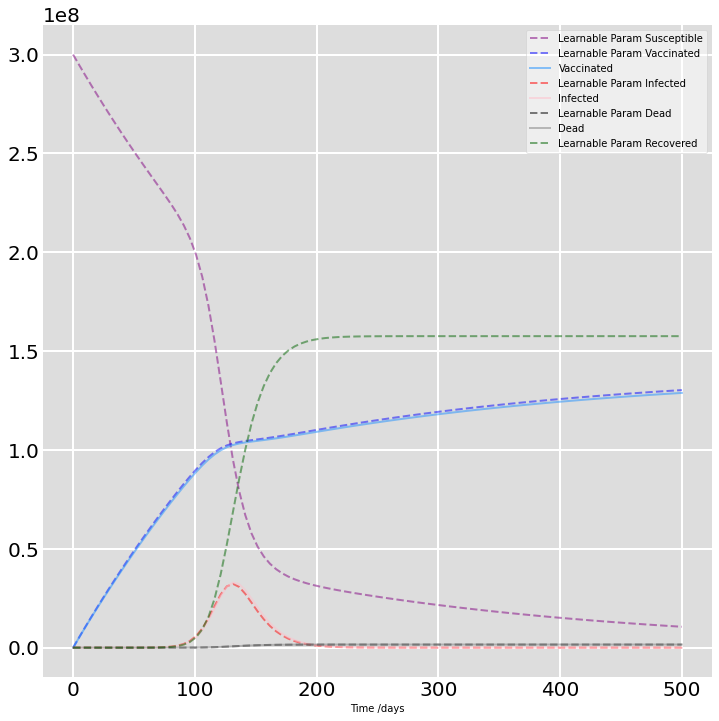

In [8]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions
N = 3e8

S0 = N - 1
V0 = 0
I0 = 1
D0 = 0
R0 = 0
# A grid of time points (in days)
t = np.linspace(0, 500, 100) 

#parameters
alpha = dinn.alpha.detach().numpy().item()
beta = dinn.beta.detach().numpy().item()
sigma = dinn.sigma.detach().numpy().item()
lbda = dinn.lbda.detach().numpy().item()
rho = dinn.rho.detach().numpy().item()
print('alpha: (goal 3.5e-3 ', alpha)
print('beta: (goal 0.3 ', beta)
print('sigma: (goal 0.05 ', sigma)
print('lbda: (goal 1e-3 ', lbda)
print('rho: (goal 0.1 ', rho)
print('#################################')

# The SIR model differential equations.
def deriv(y, t, alpha, beta, sigma, lbda, rho):
    S, V, I, D, R = y
    dSdt = - beta/N * S * I - alpha * S
    dVdt = alpha * S - sigma * beta/N * V * I
    dIdt = beta/N * S * I + sigma * beta/N * V * I - lbda * I - rho * I 
    dDdt = lbda * I
    dRdt = rho * I

    return dSdt, dVdt, dIdt, dDdt, dRdt


# Initial conditions vector
y0 = S0, V0, I0, D0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(alpha, beta, sigma, lbda, rho))
S, V, I, D, R = ret.T

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(facecolor='w', figsize=(12,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

ax.plot(t, S, 'purple', alpha=0.5, lw=2, label='Learnable Param Susceptible', linestyle='dashed')
# ax.plot(t, sidr_data[1], 'violet', alpha=0.5, lw=2, label='Susceptible')

ax.plot(t, V, 'blue', alpha=0.5, lw=2, label='Learnable Param Vaccinated', linestyle='dashed')
ax.plot(t, sidr_data[2], 'dodgerblue', alpha=0.5, lw=2, label='Vaccinated')

ax.plot(t, I, 'red', alpha=0.5, lw=2, label='Learnable Param Infected', linestyle='dashed')
ax.plot(t, sidr_data[3], 'pink', alpha=0.5, lw=2, label='Infected')

ax.plot(t, D, 'black', alpha=0.5, lw=2, label='Learnable Param Dead', linestyle='dashed')
ax.plot(t, sidr_data[4], 'grey', alpha=0.5, lw=2, label='Dead')

ax.plot(t, R, 'darkgreen', alpha=0.5, lw=2, label='Learnable Param Recovered', linestyle='dashed')
# ax.plot(t, sidr_data[5], 'green', alpha=0.5, lw=2, label='Recovered')

ax.set_xlabel('Time /days')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [9]:
#calculate relative MSE loss
import math

S_total_loss = 0
S_den = 0
V_total_loss = 0
V_den = 0
I_total_loss = 0
I_den = 0
D_total_loss = 0
D_den = 0
R_total_loss = 0
R_den = 0

for timestep in range(len(t)):
  S_value = sidr_data[1][timestep] - S[timestep]
  S_total_loss += S_value**2
  S_den += (sidr_data[1][timestep])**2

  V_value = sidr_data[1][timestep] - V[timestep]
  V_total_loss += V_value**2
  V_den += (sidr_data[1][timestep])**2

  I_value = sidr_data[3][timestep] - I[timestep]
  I_total_loss += I_value**2
  I_den += (sidr_data[3][timestep])**2

  D_value = sidr_data[4][timestep] - D[timestep]
  D_total_loss += D_value**2
  D_den += (sidr_data[4][timestep])**2

  R_value = sidr_data[5][timestep] - R[timestep]
  R_total_loss += R_value**2
  R_den += (sidr_data[5][timestep])**2

S_total_loss = math.sqrt(S_total_loss/S_den)
V_total_loss = math.sqrt(V_total_loss/V_den)
I_total_loss = math.sqrt(I_total_loss/I_den)
D_total_loss = math.sqrt(D_total_loss/D_den)
R_total_loss = math.sqrt(R_total_loss/R_den)

print('S_total_loss: ', S_total_loss)
print('V_total_loss: ', V_total_loss)
print('I_total_loss: ', I_total_loss)
print('D_total_loss: ', D_total_loss)
print('R_total_loss: ', R_total_loss)

S_total_loss:  0.011052660747961027
V_total_loss:  1.0380100172338524
I_total_loss:  0.06241938128677601
D_total_loss:  0.022440445070844906
R_total_loss:  0.011198701303688063
